In [1]:
import pandas as pd
import numpy as np
import os

from typing import List, Tuple

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import missingno as msno

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')


pd.options.display.max_rows=100
pd.options.display.max_columns=250

import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
from datetime import timedelta, datetime, date

In [3]:
def get_input(data_path):
    data = pd.read_csv(data_path)
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [4]:
path = 'row_data'
os.listdir(path)

['applications_history.csv',
 'bki.csv',
 'client_profile.csv',
 'payments.csv',
 'test.csv',
 'train.csv']

In [5]:
train_df = get_input(f'{path}/train.csv')
test_df = get_input(f'{path}/test.csv')

row_data/train.csv: shape = 110093 rows, 3 cols
row_data/test.csv: shape = 165141 rows, 2 cols


In [6]:
bki_df = get_input(f'{path}/bki.csv')

row_data/bki.csv: shape = 945234 rows, 17 cols


In [7]:
client_profile_df = get_input(f'{path}/client_profile.csv')

row_data/client_profile.csv: shape = 250000 rows, 24 cols


In [8]:
client_profile_df.head(2)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


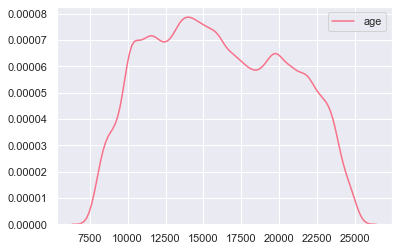

In [9]:
sns.kdeplot(client_profile_df.age)

In [10]:
client_profile_df['age_years'] = client_profile_df.age.apply(lambda x: timedelta(days=x)/365)
client_profile_df['age_years'] = client_profile_df['age_years'].astype('str')
client_profile_df['age_years'] = client_profile_df['age_years'].apply(lambda x: re.findall('^\d\d', x)[0])
client_profile_df['age_years'] = client_profile_df['age_years'].astype('int')
client_profile_df['age_cat'] = 1
client_profile_df.loc[client_profile_df['age_years'] > 30, 'age_cat'] = 2
client_profile_df.loc[client_profile_df['age_years'] > 50, 'age_cat'] = 3

In [11]:
payments_df = get_input(f'{path}/payments.csv')

row_data/payments.csv: shape = 1023932 rows, 8 cols


In [12]:
payments_df['days_of_delay'] = payments_df['days_instalment'].copy() - payments_df['days_entry_payment'].copy()
payments_df['amt_of_delay'] = payments_df['amt_instalment'].copy() - payments_df['amt_payment'].copy()
payments_df['product_of_delay'] = payments_df['days_of_delay'].copy() * payments_df['amt_of_delay'].copy()

payments_mean = payments_df.groupby('application_number')[['num_instalment_version', 'num_instalment_number', 'days_instalment',
       'days_entry_payment', 'amt_instalment', 'amt_payment', 'days_of_delay',
       'amt_of_delay', 'product_of_delay']].mean().reset_index()

payments_sum = payments_df.groupby('application_number')[['num_instalment_version', 'num_instalment_number', 'days_instalment',
       'days_entry_payment', 'amt_instalment', 'amt_payment', 'days_of_delay',
       'amt_of_delay', 'product_of_delay']].sum().reset_index()

payments_sum = payments_sum.rename(columns={'num_instalment_version': 'num_instalment_version_sum', 
                                            'num_instalment_number': 'num_instalment_number_sum',
                                            'days_instalment': 'days_instalment_sum',
                                            'days_entry_payment': 'days_entry_payment_sum',
                                            'amt_instalment': 'amt_instalment_sum', 
                                            'amt_payment': 'amt_payment_sum', 
                                            'days_of_delay': 'days_of_delay_sum',
                                            'amt_of_delay': 'amt_of_delay_sum', 
                                            'product_of_delay': 'product_of_delay_sum'})

In [13]:
applications_history_df = get_input(f'{path}/applications_history.csv')

row_data/applications_history.csv: shape = 1670214 rows, 26 cols


In [14]:
applications_history_df.head(2)

,prev_application_number,application_number,name_contract_type,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,sellerplace_area,cnt_payment,name_yield_group,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [15]:
applications_history_df['name_contract_status'].value_counts()

approved = applications_history_df.loc[applications_history_df['name_contract_status'] == 'Approved'].select_dtypes('number')

approved = approved.replace(365243, np.nan)

current_credits = approved.loc[approved['days_termination'].isnull()]

current_credits.groupby('application_number').sum().reset_index().drop(columns=['prev_application_number'])

,application_number,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,days_decision,sellerplace_area,cnt_payment,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,123423345,82482.030,1059417.0,1019425.5,66987.0,1059417.0,930,8023,30.0,0.0,281.0,49.0,0.0,0.0,0.0
1,123423346,29048.625,472500.0,558688.5,0.0,472500.0,1241,3,72.0,0.0,344.0,346.0,0.0,0.0,1.0
2,123423348,10418.670,95841.0,88632.0,14377.5,95841.0,74,300,10.0,0.0,43.0,227.0,0.0,0.0,0.0
3,123423350,9000.000,0.0,180000.0,0.0,0.0,2279,0,0.0,2277.0,2229.0,0.0,1257.0,0.0,0.0
4,123423353,14045.625,73800.0,73800.0,0.0,73800.0,102,30,6.0,0.0,64.0,86.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188782,123779584,6481.755,90000.0,116077.5,0.0,90000.0,222,4,24.0,0.0,192.0,498.0,0.0,0.0,1.0
188783,123779585,6750.000,0.0,135000.0,0.0,0.0,278,30,0.0,256.0,231.0,0.0,0.0,0.0,0.0
188784,123779587,45000.000,0.0,900000.0,0.0,0.0,740,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188785,123779589,16847.685,246091.5,246091.5,0.0,246091.5,700,35,12.0,373.0,603.0,54.0,0.0,0.0,0.0


In [16]:
train_client_profile = train_df.merge(client_profile_df, how='left')

In [17]:
train_client_profile = train_client_profile.merge(payments_mean, how='left')

train_client_profile = train_client_profile.merge(payments_sum, how='left')

In [18]:
test_client_profile = test_df.merge(client_profile_df, how='left')

In [19]:
test_client_profile = test_client_profile.merge(payments_mean, how='left')

test_client_profile = test_client_profile.merge(payments_sum, how='left')

### Пропуски

In [20]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [21]:
check_missings(train_client_profile)

Total NA-values = 1219867


,application_number,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,age_years,age_cat,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,days_of_delay,amt_of_delay,product_of_delay,num_instalment_version_sum,num_instalment_number_sum,days_instalment_sum,days_entry_payment_sum,amt_instalment_sum,amt_payment_sum,days_of_delay_sum,amt_of_delay_sum,product_of_delay_sum
Total,0,0,0,20554,20554,20554,20554,20559,20554,20554,20554,20554,20554,79560,20554,20554,20555,71002,20748,38285,32613,32613,32613,32613,32613,32613,20554,20554,28126,28126,28126,28128,28126,28128,28128,28128,28128,28126,28126,28126,28126,28126,28126,28126,28126,28126
Percent,0,0,0,18.6697,18.6697,18.6697,18.6697,18.6742,18.6697,18.6697,18.6697,18.6697,18.6697,72.2662,18.6697,18.6697,18.6706,64.4927,18.8459,34.7751,29.6231,29.6231,29.6231,29.6231,29.6231,29.6231,18.6697,18.6697,25.5475,25.5475,25.5475,25.5493,25.5475,25.5493,25.5493,25.5493,25.5493,25.5475,25.5475,25.5475,25.5475,25.5475,25.5475,25.5475,25.5475,25.5475
Types,int64,int64,object,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [22]:
check_missings(test_client_profile)

Total NA-values = 1840397


,application_number,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,age_years,age_cat,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,days_of_delay,amt_of_delay,product_of_delay,num_instalment_version_sum,num_instalment_number_sum,days_instalment_sum,days_entry_payment_sum,amt_instalment_sum,amt_payment_sum,days_of_delay_sum,amt_of_delay_sum,product_of_delay_sum
Total,0,0,30965,30965,30965,30965,30971,30965,30965,30965,30965,30965,119640,30965,30965,30966,106506,31250,57641,49104,49104,49104,49104,49104,49104,30965,30965,42568,42568,42568,42574,42568,42574,42574,42574,42574,42568,42568,42568,42568,42568,42568,42568,42568,42568
Percent,0,0,18.7506,18.7506,18.7506,18.7506,18.7543,18.7506,18.7506,18.7506,18.7506,18.7506,72.4472,18.7506,18.7506,18.7512,64.494,18.9232,34.9041,29.7346,29.7346,29.7346,29.7346,29.7346,29.7346,18.7506,18.7506,25.7768,25.7768,25.7768,25.7804,25.7768,25.7804,25.7804,25.7804,25.7804,25.7768,25.7768,25.7768,25.7768,25.7768,25.7768,25.7768,25.7768,25.7768
Types,int64,object,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Построение списков признаков

#### Количественные признаки

In [23]:
quantitative_features = train_client_profile.select_dtypes('int64').drop(columns=['target', 'application_number']).columns.tolist()
quantitative_features

[]

#### Категориальные признаки

In [24]:
cat_features = train_client_profile.select_dtypes('object').columns.tolist()
cat_features

['name_contract_type', 'gender', 'education_level', 'family_status']

In [25]:
for col in cat_features:
    print(col)
    print(train_client_profile[col].value_counts())
    print(train_client_profile[col].isnull().sum())
    print()

name_contract_type
Cash           99551
Credit Card    10542
Name: name_contract_type, dtype: int64
0

gender
F      59077
M      30461
XNA        1
Name: gender, dtype: int64
20554

education_level
Secondary / secondary special    63506
Higher education                 21802
Incomplete higher                 3081
Lower secondary                   1113
Academic degree                     37
Name: education_level, dtype: int64
20554

family_status
Married                 57236
Single / not married    13147
Civil marriage           8736
Separated                5763
Widow                    4656
Unknown                     1
Name: family_status, dtype: int64
20554



In [26]:
# train_client_profile[cat_features] = train_client_profile[cat_features].fillna('missing')

In [27]:
# test_client_profile[cat_features] = test_client_profile[cat_features].fillna('missing')

In [28]:
for col in cat_features:
    train_client_profile[col] = train_client_profile[col].astype('str')
    test_client_profile[col] = test_client_profile[col].astype('str')

In [29]:
train_client_profile[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 4 columns):
name_contract_type    110093 non-null object
gender                110093 non-null object
education_level       110093 non-null object
family_status         110093 non-null object
dtypes: object(4)
memory usage: 4.2+ MB


#### Вещественные признаки

In [30]:
float_features = train_client_profile.select_dtypes('float64').columns.tolist()
len(float_features)

40

In [31]:
train_nunique = train_client_profile[float_features].apply(lambda x: x.nunique(dropna=False))
train_nunique.shape

(40,)

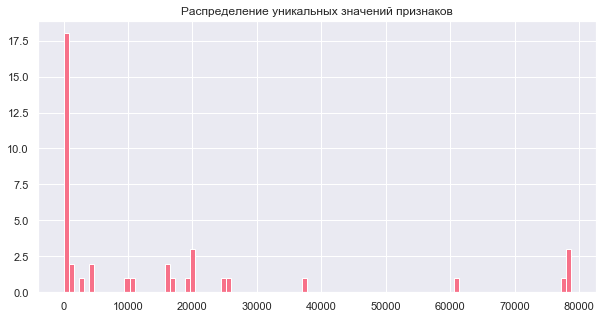

In [32]:
plt.title("Распределение уникальных значений признаков");
train_nunique.hist(bins=100, figsize=(10, 5));

In [33]:
all_features = set(train_nunique.index.tolist())
len(all_features)

40

In [34]:
const_features = set(train_nunique[train_nunique == 1].index.tolist())
const_features

set()

In [35]:
numeric_features = (train_client_profile[float_features].fillna(0).astype(int).sum() - train_client_profile[float_features].fillna(0).sum()).abs()
numeric_features = set(numeric_features[numeric_features > 0].index.tolist())
len(numeric_features)

20

In [36]:
train_client_profile[numeric_features].describe()

,external_scoring_rating_2,amt_of_delay,amount_credit,region_population,amt_instalment_sum,amt_instalment,product_of_delay_sum,num_instalment_number,amt_payment_sum,days_instalment,amt_payment,days_of_delay,external_scoring_rating_3,product_of_delay,external_scoring_rating_1,amount_annuity,num_instalment_version,days_entry_payment,amt_of_delay_sum,total_salary
count,89345.000000,8.196500e+04,8.953900e+04,89539.000000,8.196700e+04,8.196700e+04,8.196700e+04,81967.000000,8.196700e+04,81967.000000,8.196500e+04,81965.000000,71808.000000,8.196500e+04,39091.000000,89534.000000,81967.000000,81965.000000,8.196700e+04,8.953900e+04
mean,0.513890,-3.834735e+02,5.997495e+05,0.020843,6.637750e+04,1.808100e+04,1.534194e+04,11.252044,6.731353e+04,937.699897,1.846368e+04,-10.620955,0.511020,6.847054e+03,0.501400,27119.655449,1.017278,948.420653,-9.453261e+02,1.683230e+05
std,0.191253,1.345652e+04,4.031694e+05,0.013797,1.237296e+05,3.889421e+04,8.074758e+05,13.532577,1.330824e+05,653.900995,4.192963e+04,21.965340,0.195153,3.050630e+05,0.209929,14503.018565,0.786610,653.005518,4.148372e+04,9.962278e+04
min,0.000010,-1.237264e+06,4.500000e+04,0.000533,4.500000e-02,4.500000e-02,-1.025110e+07,1.000000,0.000000e+00,2.000000,4.500000e-02,-381.000000,0.000527,-3.055371e+06,0.014691,1615.500000,0.000000,3.000000,-1.961145e+06,2.565000e+04
25%,0.391285,0.000000e+00,2.700000e+05,0.010006,1.267225e+04,6.388875e+03,0.000000e+00,4.000000,1.197466e+04,402.000000,5.961375e+03,-15.000000,0.370650,0.000000e+00,0.334582,16524.000000,1.000000,413.333333,0.000000e+00,1.125000e+05
50%,0.565177,0.000000e+00,5.177880e+05,0.018850,2.945736e+04,1.073205e+04,0.000000e+00,7.000000,2.825073e+04,801.000000,1.024227e+04,-8.714286,0.535276,0.000000e+00,0.504836,24903.000000,1.000000,811.888889,0.000000e+00,1.485000e+05
75%,0.663661,0.000000e+00,8.086500e+05,0.028663,6.910132e+04,1.845309e+04,0.000000e+00,11.333333,6.705452e+04,1364.450000,1.809547e+04,-4.000000,0.669057,0.000000e+00,0.671532,34596.000000,1.000000,1374.000000,0.000000e+00,2.025000e+05
max,0.855000,1.328422e+05,4.050000e+06,0.072508,3.266929e+06,2.383749e+06,4.218710e+07,150.500000,4.742581e+06,2922.000000,2.476718e+06,2502.000000,0.896010,3.711792e+07,0.951624,225000.000000,31.500000,2953.000000,4.109711e+05,4.500000e+06


In [37]:
train_client_profile[numeric_features].isnull().sum()

external_scoring_rating_2    20748
amt_of_delay                 28128
amount_credit                20554
region_population            20554
amt_instalment_sum           28126
amt_instalment               28126
product_of_delay_sum         28126
num_instalment_number        28126
amt_payment_sum              28126
days_instalment              28126
amt_payment                  28128
days_of_delay                28128
external_scoring_rating_3    38285
product_of_delay             28128
external_scoring_rating_1    71002
amount_annuity               20559
num_instalment_version       28126
days_entry_payment           28128
amt_of_delay_sum             28126
total_salary                 20554
dtype: int64

In [38]:
other = all_features - (numeric_features | const_features)
len(other)

20

#### Бинарные признаки

In [39]:
boolean = set(train_client_profile.loc[:, other].columns[(
                      (train_client_profile.loc[:, other].max() == 1) & \
                      (train_client_profile.loc[:, other].min() == 0))])
len(boolean)

2

In [40]:
for col in boolean:
    print(col)
    print(train_client_profile[col].value_counts())
    print(train_client_profile[col].isnull().sum())
    print()

flag_email
0.0    84581
1.0     4958
Name: flag_email, dtype: int64
20554

flag_phone
0.0    64272
1.0    25267
Name: flag_phone, dtype: int64
20554



In [41]:
train_client_profile['flag_phone'] = train_client_profile['flag_phone'].fillna(0)
train_client_profile['flag_phone'] = train_client_profile['flag_phone'].astype('int')

In [42]:
test_client_profile['flag_phone'] = test_client_profile['flag_phone'].fillna(0)
test_client_profile['flag_phone'] = test_client_profile['flag_phone'].astype('int')

In [43]:
train_client_profile['flag_email'] = train_client_profile['flag_email'].fillna(0)
train_client_profile['flag_email'] = train_client_profile['flag_email'].astype('int')
test_client_profile['flag_email'] = test_client_profile['flag_email'].fillna(0)
test_client_profile['flag_email'] = test_client_profile['flag_email'].astype('int')

In [44]:
other = other - boolean
len(other)

18

In [45]:
train_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 46 columns):
application_number            110093 non-null int64
target                        110093 non-null int64
name_contract_type            110093 non-null object
gender                        110093 non-null object
childrens                     89539 non-null float64
total_salary                  89539 non-null float64
amount_credit                 89539 non-null float64
amount_annuity                89534 non-null float64
education_level               110093 non-null object
family_status                 110093 non-null object
region_population             89539 non-null float64
age                           89539 non-null float64
days_on_last_job              89539 non-null float64
own_car_age                   30533 non-null float64
flag_phone                    110093 non-null int32
flag_email                    110093 non-null int32
family_size                   89538 non-null 

In [46]:
# train_client_profile['own_car_age'] = train_client_profile['own_car_age'].fillna(-1)
# train_client_profile['own_car_age'] = train_client_profile['own_car_age'].astype('int')
# test_client_profile['own_car_age'] = test_client_profile['own_car_age'].fillna(-1)
# test_client_profile['own_car_age'] = test_client_profile['own_car_age'].astype('int')

In [47]:
numeric_features = numeric_features | other

In [48]:
other = other - numeric_features
len(other)

0

In [49]:
train_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 46 columns):
application_number            110093 non-null int64
target                        110093 non-null int64
name_contract_type            110093 non-null object
gender                        110093 non-null object
childrens                     89539 non-null float64
total_salary                  89539 non-null float64
amount_credit                 89539 non-null float64
amount_annuity                89534 non-null float64
education_level               110093 non-null object
family_status                 110093 non-null object
region_population             89539 non-null float64
age                           89539 non-null float64
days_on_last_job              89539 non-null float64
own_car_age                   30533 non-null float64
flag_phone                    110093 non-null int32
flag_email                    110093 non-null int32
family_size                   89538 non-null 

In [50]:
numeric_features = train_client_profile.select_dtypes(include=['number']).drop(
    columns=['target', 'application_number']).columns.tolist()
len(numeric_features)

40

In [51]:
# train_client_profile[numeric_features].fillna(-1, inplace=True)

In [52]:
# test_client_profile[numeric_features].fillna(-1, inplace=True)

In [53]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, -1)
#     bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
#     X["bki_requests_count"] = X[bki_flags].sum(axis=1)
#     X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

#     # Отношение врменных признаков
#     X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
#     X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
#     X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
#     X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

#     # Произведение фин. показателей кредита на вероятность дефолта
#     # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
#     X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
#     X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
#     X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
#     X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
#     X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
#     X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

In [54]:
train_client_profile = create_client_profile_features(train_client_profile)

In [55]:
train_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 62 columns):
application_number                   110093 non-null int64
target                               110093 non-null int64
name_contract_type                   110093 non-null object
gender                               110093 non-null object
childrens                            89539 non-null float64
total_salary                         89539 non-null float64
amount_credit                        89539 non-null float64
amount_annuity                       89534 non-null float64
education_level                      110093 non-null object
family_status                        110093 non-null object
region_population                    89539 non-null float64
age                                  89539 non-null float64
days_on_last_job                     89539 non-null float64
own_car_age                          30533 non-null float64
flag_phone                           110093 non-nul

In [56]:
test_client_profile = create_client_profile_features(test_client_profile)

In [57]:
def fit_catboost(x_train, y_train, model_params, cat_features, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_valid, y_valid)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=cat_features
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

In [58]:
x_train, x_valid = train_test_split(
    train_client_profile[numeric_features + cat_features], train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train_client_profile["target"], train_size=0.7, random_state=27, shuffle=True
)

In [59]:
cb_params_1000 = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 1
}

model = fit_catboost(x_train, y_train, cb_params_1000, cat_features, x_valid, y_valid)

0:	test: 0.6196003	best: 0.6196003 (0)	total: 253ms	remaining: 6m 19s
10:	test: 0.6750349	best: 0.6750349 (10)	total: 1.55s	remaining: 3m 29s
20:	test: 0.6820890	best: 0.6820890 (20)	total: 2.73s	remaining: 3m 12s
30:	test: 0.6875278	best: 0.6878489 (29)	total: 3.96s	remaining: 3m 7s
40:	test: 0.6931282	best: 0.6935014 (38)	total: 5.31s	remaining: 3m 8s
50:	test: 0.6973042	best: 0.6973042 (50)	total: 6.74s	remaining: 3m 11s
60:	test: 0.6978178	best: 0.6978178 (60)	total: 8.13s	remaining: 3m 11s
70:	test: 0.6978005	best: 0.6980048 (69)	total: 9.49s	remaining: 3m 11s
80:	test: 0.6988173	best: 0.6988778 (79)	total: 10.8s	remaining: 3m 9s
90:	test: 0.6995791	best: 0.6996802 (88)	total: 12.2s	remaining: 3m 9s
100:	test: 0.6992445	best: 0.6997506 (95)	total: 13.7s	remaining: 3m 9s
110:	test: 0.7007710	best: 0.7007710 (110)	total: 15s	remaining: 3m 8s
120:	test: 0.7020957	best: 0.7020957 (120)	total: 16.4s	remaining: 3m 6s
130:	test: 0.7028592	best: 0.7028592 (130)	total: 17.8s	remaining: 3m 

1110:	test: 0.7287952	best: 0.7287970 (1109)	total: 2m 13s	remaining: 46.9s
1120:	test: 0.7288046	best: 0.7288151 (1117)	total: 2m 14s	remaining: 45.6s
1130:	test: 0.7289036	best: 0.7289041 (1129)	total: 2m 16s	remaining: 44.4s
1140:	test: 0.7289635	best: 0.7289789 (1138)	total: 2m 17s	remaining: 43.1s
1150:	test: 0.7290000	best: 0.7290000 (1150)	total: 2m 18s	remaining: 41.9s
1160:	test: 0.7291067	best: 0.7291067 (1159)	total: 2m 19s	remaining: 40.7s
1170:	test: 0.7291123	best: 0.7291239 (1166)	total: 2m 20s	remaining: 39.5s
1180:	test: 0.7291052	best: 0.7291239 (1166)	total: 2m 21s	remaining: 38.3s
1190:	test: 0.7291640	best: 0.7291640 (1190)	total: 2m 22s	remaining: 37.1s
1200:	test: 0.7291622	best: 0.7291722 (1192)	total: 2m 24s	remaining: 35.9s
1210:	test: 0.7291596	best: 0.7291722 (1192)	total: 2m 25s	remaining: 34.7s
1220:	test: 0.7291567	best: 0.7291722 (1192)	total: 2m 26s	remaining: 33.5s
1230:	test: 0.7291881	best: 0.7291881 (1230)	total: 2m 27s	remaining: 32.3s
1240:	test: 

In [60]:
evaluate_model(model, x_train, y_train, x_valid, y_valid)

score = 0.743251
score = 0.729979


In [61]:
# с пропусками
# score = 0.743913
# score = 0.729956

In [62]:
# с платежами
# score = 0.744631
# score = 0.72949

In [63]:
# мои данные
# score = 0.740229
# score = 0.729069

In [64]:
# со всей функцией
# score = 0.739857
# score = 0.729562

In [65]:
# score = 0.73188
# score = 0.723108

In [66]:
preds = model.predict_proba(test_client_profile[numeric_features + cat_features])

In [67]:
test_df['target'] = preds[:, 1]

In [68]:
test_df.head(2)

,application_number,name_contract_type,target
0,123724268,Cash,0.071787
1,123456549,Cash,0.216929


In [69]:
test_df[['application_number', 'target']].to_csv('ATaganova_submission.csv', index=False)

In [70]:
test_client_profile.head(2)

,application_number,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,age_years,age_cat,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,days_of_delay,amt_of_delay,product_of_delay,num_instalment_version_sum,num_instalment_number_sum,days_instalment_sum,days_entry_payment_sum,amt_instalment_sum,amt_payment_sum,days_of_delay_sum,amt_of_delay_sum,product_of_delay_sum,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,16007.0,2646.0,20.0,0,0,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0,43.0,2.0,1.0,7.5,494.0,504.0,11175.6150,11175.6150,-10.0,0.0,0.0,2.0,15.0,988.0,1008.0,22351.230,22351.230,-20.0,0.0,0.0,NaN,NaN,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,2.055038,70.281752,7.309302,44.217687,425.170068,12.431973
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,10315.0,459.0,NaN,0,0,4.0,NaN,0.578161,0.18849,0.0,0.0,1.0,0.0,0.0,2.0,28.0,1.0,2.5,53.5,481.0,474.0,24610.3875,24610.3875,7.0,0.0,0.0,5.0,107.0,962.0,948.0,49220.775,49220.775,14.0,0.0,0.0,NaN,NaN,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,1.657344,30.321667,7.852642,176.470588,681.411765,37.245098


In [71]:
def create_bootstrap_samples(data: np.array, n_samples: int = 5000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 5000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [72]:
np.random.seed(27)
y_pred_test = model.predict_proba(x_valid)[:, 1]
scores = create_bootstrap_metrics(y_valid, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.7198708998136641, 0.7393822167789091)

In [73]:
# с пропусками
# (0.7199146067343425, 0.7393311094281888)

In [74]:
# (0.7199413669382881, 0.7393467045216955)

In [75]:
# с платежами
# (0.7195918892212818, 0.739013029326716)

In [76]:
# мои данные
# (0.7191137555607668, 0.7381910291983609)

In [77]:
# (0.7129916838428914, 0.7327001189056468)

In [78]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          params: dict,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: dict
        Список со значением гиперпараметров модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        categorical = x_train.dtypes[x_train.dtypes == "object"].index.tolist()

        estimator = fit_catboost(
            x_train, y_train, params, categorical, x_valid, y_valid
        )    
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*80)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [79]:
target, data = train_client_profile["target"], train_client_profile[numeric_features + cat_features]

In [80]:
cv = KFold(5, shuffle=True, random_state=27)

In [81]:
%%time
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    data, target, params=cb_params_1000, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.6327931	best: 0.6327931 (0)	total: 147ms	remaining: 3m 40s
10:	test: 0.6774417	best: 0.6805999 (4)	total: 1.5s	remaining: 3m 23s
20:	test: 0.6935059	best: 0.6935059 (20)	total: 2.87s	remaining: 3m 22s
30:	test: 0.6975424	best: 0.6975424 (30)	total: 4.3s	remaining: 3m 24s
40:	test: 0.6952554	best: 0.6975424 (30)	total: 5.82s	remaining: 3m 27s
50:	test: 0.6996585	best: 0.6996585 (50)	total: 7.36s	remaining: 3m 29s
60:	test: 0.7007885	best: 0.7010474 (54)	total: 8.85s	remaining: 3m 28s
70:	test: 0.7010876	best: 0.7010876 (70)	total: 10.1s	remaining: 3m 23s
80:	test: 0.7020299	best: 0.7021761 (77)	total: 11.4s	remaining: 3m 19s
90:	test: 0.7021381	best: 0.7026403 (88)	total: 12.6s	remaining: 3m 15s
100:	test: 0.7027961	best: 0.7027961 (100)	total: 13.9s	remaining: 3m 12s
110:	test: 0.7035211	best: 0.7035211 (110)	total: 15.2s	remaining: 3m 9s
120:	test: 0.7046344	best: 0.7046344 (120)	total: 16.4s	remaining: 3m 7s
130:	test: 0.7053044	best: 0.7056014 (126)	total: 17.7s	remaining

1110:	test: 0.7339939	best: 0.7339939 (1110)	total: 2m 27s	remaining: 51.5s
1120:	test: 0.7340527	best: 0.7340527 (1120)	total: 2m 28s	remaining: 50.2s
1130:	test: 0.7342000	best: 0.7342000 (1130)	total: 2m 29s	remaining: 48.8s
1140:	test: 0.7343130	best: 0.7343130 (1140)	total: 2m 30s	remaining: 47.5s
1150:	test: 0.7344673	best: 0.7344673 (1150)	total: 2m 32s	remaining: 46.2s
1160:	test: 0.7345361	best: 0.7345361 (1160)	total: 2m 33s	remaining: 44.8s
1170:	test: 0.7346695	best: 0.7346695 (1170)	total: 2m 34s	remaining: 43.5s
1180:	test: 0.7347639	best: 0.7347685 (1179)	total: 2m 36s	remaining: 42.2s
1190:	test: 0.7348383	best: 0.7348383 (1190)	total: 2m 37s	remaining: 40.9s
1200:	test: 0.7349315	best: 0.7349315 (1200)	total: 2m 38s	remaining: 39.5s
1210:	test: 0.7350366	best: 0.7350394 (1209)	total: 2m 39s	remaining: 38.2s
1220:	test: 0.7350380	best: 0.7350394 (1209)	total: 2m 41s	remaining: 36.8s
1230:	test: 0.7350469	best: 0.7350535 (1228)	total: 2m 42s	remaining: 35.5s
1240:	test: 

670:	test: 0.7347505	best: 0.7347505 (670)	total: 1m 26s	remaining: 1m 47s
680:	test: 0.7349628	best: 0.7349628 (680)	total: 1m 27s	remaining: 1m 45s
690:	test: 0.7351132	best: 0.7351132 (690)	total: 1m 29s	remaining: 1m 44s
700:	test: 0.7353430	best: 0.7353430 (700)	total: 1m 30s	remaining: 1m 42s
710:	test: 0.7355238	best: 0.7355238 (710)	total: 1m 31s	remaining: 1m 41s
720:	test: 0.7357038	best: 0.7357038 (720)	total: 1m 32s	remaining: 1m 40s
730:	test: 0.7357462	best: 0.7357903 (728)	total: 1m 33s	remaining: 1m 38s
740:	test: 0.7359430	best: 0.7359430 (740)	total: 1m 35s	remaining: 1m 37s
750:	test: 0.7361379	best: 0.7361479 (749)	total: 1m 36s	remaining: 1m 36s
760:	test: 0.7363519	best: 0.7363519 (760)	total: 1m 37s	remaining: 1m 34s
770:	test: 0.7365208	best: 0.7365208 (770)	total: 1m 38s	remaining: 1m 33s
780:	test: 0.7367085	best: 0.7367085 (780)	total: 1m 39s	remaining: 1m 32s
790:	test: 0.7369493	best: 0.7369493 (790)	total: 1m 41s	remaining: 1m 30s
800:	test: 0.7370533	best

230:	test: 0.7216829	best: 0.7216829 (230)	total: 29.2s	remaining: 2m 40s
240:	test: 0.7225483	best: 0.7225483 (240)	total: 30.5s	remaining: 2m 39s
250:	test: 0.7233607	best: 0.7233607 (250)	total: 31.7s	remaining: 2m 37s
260:	test: 0.7237835	best: 0.7237835 (260)	total: 32.9s	remaining: 2m 36s
270:	test: 0.7242149	best: 0.7242149 (270)	total: 34.2s	remaining: 2m 35s
280:	test: 0.7247833	best: 0.7247833 (280)	total: 35.3s	remaining: 2m 33s
290:	test: 0.7252215	best: 0.7252461 (289)	total: 36.6s	remaining: 2m 32s
300:	test: 0.7256010	best: 0.7256010 (300)	total: 37.9s	remaining: 2m 30s
310:	test: 0.7260451	best: 0.7260451 (310)	total: 39.1s	remaining: 2m 29s
320:	test: 0.7263928	best: 0.7263928 (320)	total: 40.4s	remaining: 2m 28s
330:	test: 0.7268151	best: 0.7268151 (330)	total: 41.7s	remaining: 2m 27s
340:	test: 0.7272824	best: 0.7272824 (340)	total: 42.9s	remaining: 2m 25s
350:	test: 0.7276419	best: 0.7276419 (350)	total: 44.1s	remaining: 2m 24s
360:	test: 0.7282822	best: 0.7282822 (

1330:	test: 0.7482934	best: 0.7482934 (1330)	total: 2m 43s	remaining: 20.8s
1340:	test: 0.7484278	best: 0.7484281 (1339)	total: 2m 44s	remaining: 19.5s
1350:	test: 0.7486283	best: 0.7486283 (1350)	total: 2m 46s	remaining: 18.3s
1360:	test: 0.7487099	best: 0.7487099 (1359)	total: 2m 47s	remaining: 17.1s
1370:	test: 0.7487922	best: 0.7487922 (1370)	total: 2m 48s	remaining: 15.8s
1380:	test: 0.7489698	best: 0.7489698 (1380)	total: 2m 49s	remaining: 14.6s
1390:	test: 0.7491725	best: 0.7491725 (1390)	total: 2m 50s	remaining: 13.4s
1400:	test: 0.7493251	best: 0.7493251 (1400)	total: 2m 52s	remaining: 12.2s
1410:	test: 0.7494611	best: 0.7494612 (1409)	total: 2m 53s	remaining: 10.9s
1420:	test: 0.7496175	best: 0.7496175 (1420)	total: 2m 54s	remaining: 9.72s
1430:	test: 0.7497329	best: 0.7497329 (1430)	total: 2m 56s	remaining: 8.49s
1440:	test: 0.7498727	best: 0.7498727 (1440)	total: 2m 57s	remaining: 7.27s
1450:	test: 0.7500591	best: 0.7500607 (1449)	total: 2m 59s	remaining: 6.05s
1460:	test: 

890:	test: 0.7425931	best: 0.7425931 (890)	total: 2m 9s	remaining: 1m 28s
900:	test: 0.7427734	best: 0.7427734 (900)	total: 2m 10s	remaining: 1m 26s
910:	test: 0.7430525	best: 0.7430525 (910)	total: 2m 11s	remaining: 1m 25s
920:	test: 0.7432305	best: 0.7432305 (920)	total: 2m 13s	remaining: 1m 23s
930:	test: 0.7434481	best: 0.7434481 (930)	total: 2m 14s	remaining: 1m 22s
940:	test: 0.7437084	best: 0.7437084 (940)	total: 2m 16s	remaining: 1m 20s
950:	test: 0.7439674	best: 0.7439674 (950)	total: 2m 17s	remaining: 1m 19s
960:	test: 0.7441767	best: 0.7441767 (960)	total: 2m 18s	remaining: 1m 17s
970:	test: 0.7443487	best: 0.7443487 (970)	total: 2m 19s	remaining: 1m 16s
980:	test: 0.7445819	best: 0.7445819 (980)	total: 2m 21s	remaining: 1m 14s
990:	test: 0.7447516	best: 0.7447516 (990)	total: 2m 22s	remaining: 1m 13s
1000:	test: 0.7449607	best: 0.7449607 (1000)	total: 2m 23s	remaining: 1m 11s
1010:	test: 0.7451117	best: 0.7451224 (1009)	total: 2m 25s	remaining: 1m 10s
1020:	test: 0.7452887	

450:	test: 0.7306225	best: 0.7306225 (450)	total: 59.1s	remaining: 2m 17s
460:	test: 0.7309863	best: 0.7309863 (460)	total: 1m	remaining: 2m 16s
470:	test: 0.7315210	best: 0.7315210 (470)	total: 1m 1s	remaining: 2m 14s
480:	test: 0.7318543	best: 0.7318543 (480)	total: 1m 3s	remaining: 2m 13s
490:	test: 0.7322664	best: 0.7322664 (490)	total: 1m 4s	remaining: 2m 12s
500:	test: 0.7325340	best: 0.7325340 (500)	total: 1m 5s	remaining: 2m 10s
510:	test: 0.7329241	best: 0.7329241 (510)	total: 1m 6s	remaining: 2m 9s
520:	test: 0.7332405	best: 0.7332405 (520)	total: 1m 8s	remaining: 2m 8s
530:	test: 0.7335669	best: 0.7335669 (530)	total: 1m 9s	remaining: 2m 6s
540:	test: 0.7338814	best: 0.7338814 (540)	total: 1m 10s	remaining: 2m 5s
550:	test: 0.7341090	best: 0.7341090 (550)	total: 1m 11s	remaining: 2m 3s
560:	test: 0.7343048	best: 0.7343048 (560)	total: 1m 13s	remaining: 2m 2s
570:	test: 0.7345678	best: 0.7345678 (570)	total: 1m 14s	remaining: 2m 1s
580:	test: 0.7348448	best: 0.7348448 (580)	t

In [82]:
# CV-results train: 0.7446 +/- 0.002
# CV-results valid: 0.7214 +/- 0.004
# OOF-score = 0.7211
# Wall time: 6min 36s

In [83]:
# с платежами
# CV-results train: 0.7462 +/- 0.003
# CV-results valid: 0.7221 +/- 0.004
# OOF-score = 0.7218
# Wall time: 9min 33s

In [84]:
# CV-results train: 0.7394 +/- 0.003
# CV-results valid: 0.722 +/- 0.005
# OOF-score = 0.7214
# Wall time: 8min 21s

In [85]:
# CV-results train: 0.7313 +/- 0.002
# CV-results valid: 0.7162 +/- 0.005
# OOF-score = 0.7156
# Wall time: 10min 15s